<a href="https://colab.research.google.com/github/MengOonLee/BertelsmannAITrack/blob/LunarNewYear/Chinese-Zodiac-Signs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Rerun this cell again
# Colab library to upload files to notebook
from google.colab import files

# Upload your kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
# Install Kaggle library
# Make kaggle directory and downlaod data for the Lunar New Year challenge
# Unzip the downloaded folder
%%bash

pip3 install -q kaggle nonechucks
rm -rf ~/.kaggle signs *.zip
mkdir -p ~/.kaggle
mv kaggle.json ~/.kaggle/
kaggle datasets download -d elderyouth/chinese-zodiac-signs
unzip -q chinese-zodiac-signs.zip
rm -rf chinese-zodiac-signs.zip

100%|##########| 2.07G/2.07G [00:24<00:00, 90.3MB/s]


In [4]:
import torch

# Check if CUDA is available
cuda_available = torch.cuda.is_available()

# Move the model to GPU if CUDA is available
if not cuda_available:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [0]:
import numpy as np
import nonechucks
from torchvision import datasets, transforms

# Define transforms, rezise, rotate slightly, preform horizontal flip

data_dir = 'signs'

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Define transforms for the train, valid & test data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean, std)])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean, std)])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', 
                                  transform=train_transforms)
train_data = nonechucks.SafeDataset(train_data)
valid_data = datasets.ImageFolder(data_dir + '/valid', 
                                 transform=test_transforms)
valid_data = nonechucks.SafeDataset(valid_data)
test_data = datasets.ImageFolder(data_dir + '/test', 
                                 transform=test_transforms)
test_data = nonechucks.SafeDataset(test_data)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32)

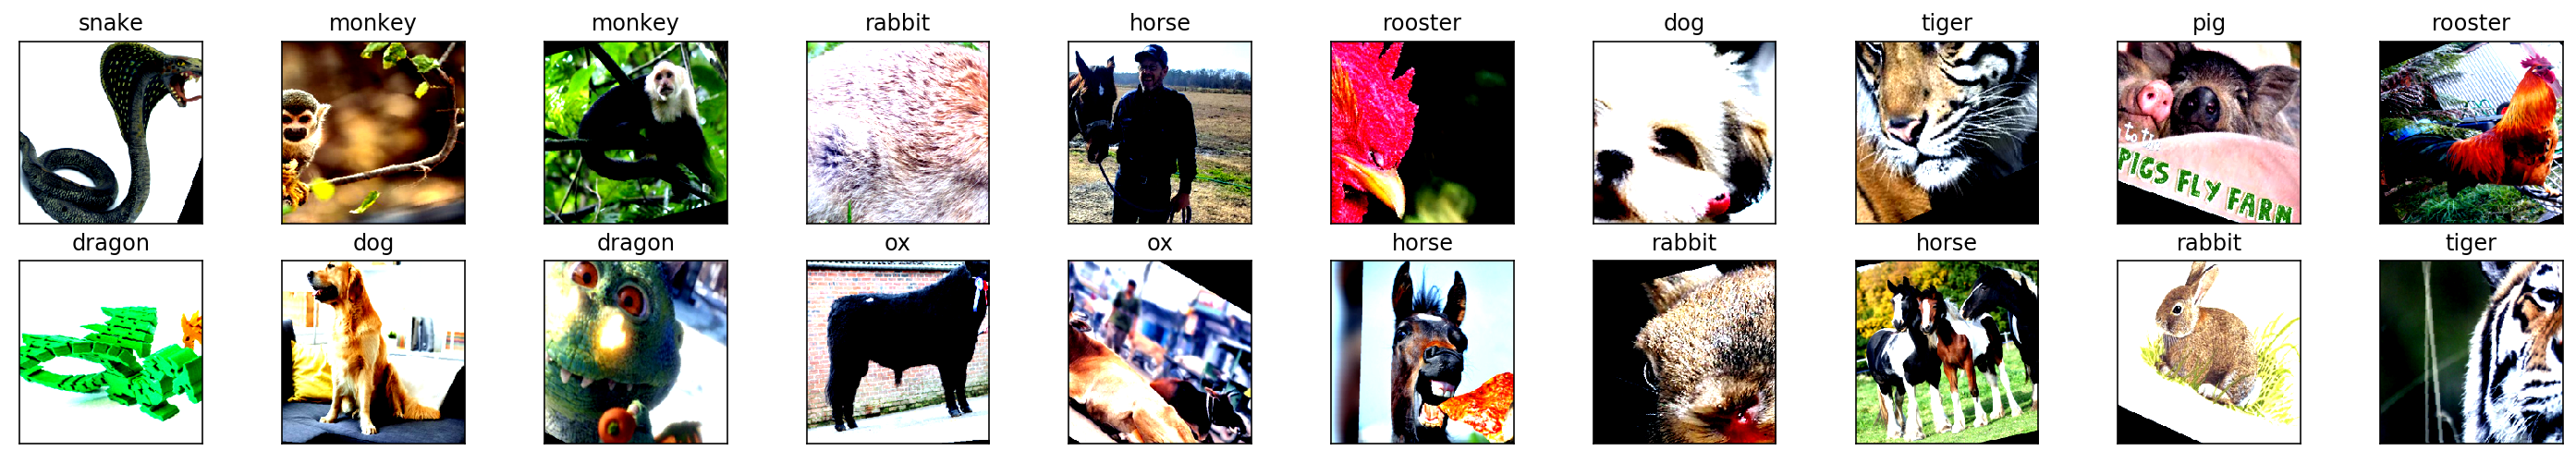

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# specify the image classes
classes = train_data.classes

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [8]:
# Load Resnet50 model

from torchvision import models
from torch import nn
import torch.nn.functional as F

resnet50 = models.resnet50(pretrained=True)

# freeze resnet50 feature parameters
for param in resnet50.parameters():
    param.requires_grad = False

# Define our new classifier
classifier = nn.Sequential(
  nn.Linear(2048, 512),
  nn.ReLU(),
  nn.Dropout(p=0.2),
  nn.Linear(512, 12),
  nn.LogSoftmax(dim=1)
)

resnet50.fc = classifier

if cuda_available:
    resnet50.cuda()

print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Train the Network¶

Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting.

In [10]:
from torch import optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.Adam(resnet50.fc.parameters(), lr=0.003)

# number of epochs to train the model
epochs = 20

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(epochs):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    resnet50.train()
    for batch_idx, (images, labels) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if cuda_available:
            images, labels = images.cuda(), labels.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = resnet50(images)
        # calculate the batch loss
        loss = criterion(output, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*images.size(0)
        
    ######################    
    # validate the model #
    ######################
    resnet50.eval()
    for batch_idx, (images, labels) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        if cuda_available:
            images, labels = images.cuda(), labels.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = resnet50(images)
        # calculate the batch loss
        loss = criterion(output, labels)
        # update average validation loss 
        valid_loss += loss.item()*images.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(resnet50.state_dict(), 'Resnet50_LunarNewYear.pt')
        valid_loss_min = valid_loss

Epoch: 0 	Training Loss: 0.641854 	Validation Loss: 0.330708
Validation loss decreased (inf --> 0.330708).  Saving model ...
Epoch: 1 	Training Loss: 0.547189 	Validation Loss: 0.328022
Validation loss decreased (0.330708 --> 0.328022).  Saving model ...
Epoch: 2 	Training Loss: 0.507792 	Validation Loss: 0.305716
Validation loss decreased (0.328022 --> 0.305716).  Saving model ...
Epoch: 3 	Training Loss: 0.458943 	Validation Loss: 0.241118
Validation loss decreased (0.305716 --> 0.241118).  Saving model ...
Epoch: 4 	Training Loss: 0.457559 	Validation Loss: 0.290567
Epoch: 5 	Training Loss: 0.433963 	Validation Loss: 0.290046
Epoch: 6 	Training Loss: 0.405434 	Validation Loss: 0.251647
Epoch: 7 	Training Loss: 0.388619 	Validation Loss: 0.265835
Epoch: 8 	Training Loss: 0.392141 	Validation Loss: 0.265359
Epoch: 9 	Training Loss: 0.361787 	Validation Loss: 0.292601
Epoch: 10 	Training Loss: 0.351309 	Validation Loss: 0.256265
Epoch: 11 	Training Loss: 0.360445 	Validation Loss: 0.27